# Readme
- 2020.06.24 : MobileNet feature-extraction 을 통한, KNN 접근(faiss - 데이터 규모가 커진다면)

# 넥라인 데이터

In [ ]:
from tqdm import tqdm
import numpy as np

import os
import glob
import zipfile

#from PIL import Image # PIL은 조금 무거운것 같다
import cv2 # (주의)imshow 할때는 google에서 제공하는 lib 써야한다(아래 Lib)
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

import pandas as pd

from tqdm.notebook import tqdm, tqdm_notebook



---



---



---



# 1. Input Data 준비
- 데이터 프레임 활용
> - img_path /  status(label)

In [ ]:
### for train - get  path / status ###

total_path = []
total_status = []

### class 17 에 대해서 - path/bbox 얻는 작업 ###
for img_path in tqdm_notebook( glob.glob('crop_neckline_filtering/*') ):
  total_path.append(img_path)
  total_status.append( img_path.split('_')[3] )

In [ ]:
print(len(total_path))
print(len(total_status))

617
617




---



---



In [ ]:
## dataframe 만들기

df = pd.DataFrame({'filename':total_path,  'status':total_status})

df.head()

,filename,status
0,crop_neckline_filtering/class_1_265.jpg,1
1,crop_neckline_filtering/class_1_260.jpg,1
2,crop_neckline_filtering/class_1_202.jpg,1
3,crop_neckline_filtering/class_1_197.jpg,1
4,crop_neckline_filtering/class_1_223.jpg,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  617 non-null    object
 1   status    617 non-null    object
dtypes: object(2)
memory usage: 9.8+ KB


In [ ]:
df['status'] = df['status'].astype(int)

In [ ]:
df.groupby('status').size()

status
0    187
1    219
2    211
dtype: int64

In [ ]:
# split dataframe / train(0.8), test(0.2)
total_data_count = len(df)
train_index = np.random.choice(len(df), int(0.8*len(df)), replace=False )


df_train = df[ df.index.isin(train_index)].reset_index(drop=True)
df_valid = df[~df.index.isin(train_index)].reset_index(drop=True)

In [ ]:
print(len(df_train), len(df_valid) )

426 124


## # 훈련셋만 균형지게 만들기
- 평소에는 up-sampling 이용했는데,  faiss부터는 under-sampling 이용하자

In [ ]:
# equal-sized 데이터 만들기

def make_equal_size(df, class_name=None):
  if not class_name:
    class_name = 'status'
  min_class = df[class_name].value_counts().index[-1]
  size = df[df[class_name] == min_class].shape[0]

  df_equal_size = pd.DataFrame()
  for class_key, grp in df.groupby(class_name):
    if class_key == min_class:
      df_equal_size = pd.concat([df_equal_size, grp], axis=0)
    else:
      equal_sampled = grp.sample(n = size, replace=True)
      df_equal_size = pd.concat([df_equal_size, equal_sampled], axis=0)
  
  df_equal_size = df_equal_size.reset_index(drop=True)
  return df_equal_size

In [ ]:
# 불균형 데이터 맞춰준다
df_train = make_equal_size(df = df_train)

In [ ]:
df_train.groupby('status').size()

status
0    142
1    142
2    142
dtype: int64



---



---



# 1.1 data load

In [ ]:
# defining a function to resize images
def img_prep(features, output, dims):

    img_data = []
    labels = []

    for enum, imagePath in tqdm(enumerate(features)):
    
        try:
            counter = 0
            img=cv2.imread(imagePath)
            #img=cv2.resize(img, (dims[1], dims[0]))
            
            ### scaling ###
            img = np.array(img, dtype = np.float32)/255.
            
            
        except Exception as e:
        
            counter = 1
    
        if counter==0:
            
            label = output[enum]
            labels.append(label)
        
            img_data.append(img)
            
    return img_data, labels

In [ ]:
# preprocessing training and validation sets
IMAGE_DIMS = (192, 192, 3)

train_X, train_y = img_prep( df_train['filename'].tolist(), df_train['status'].tolist(), IMAGE_DIMS)
val_X, val_y     = img_prep( df_valid['filename'].tolist(), df_valid['status'].tolist(), IMAGE_DIMS)

In [ ]:
train_X[0].shape

(192, 192, 3)

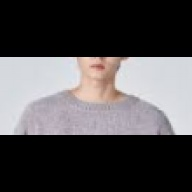

In [ ]:
cv2_imshow(train_X[0] * 255)



---



---



# 2. feature extraction

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
def normalize_feat(self, v):
    v = v / np.linalg.norm(v)
    return v

def extract_feat(img_array):
  
  hub_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_025_192/feature_vector/4"

  embed = hub.KerasLayer(hub_url)
  embed.build([None, 192, 192, 3])

  data = [] # extracted features 쌓을 list(나중에 numpy 로 받을거야)

  for img in tqdm(img_array):
    img = img.reshape(1,192,192,3)
    features = embed(img).numpy().squeeze()
    normalized_features = features/np.linalg.norm(features)
    data.append(normalized_features)
  
  stacked_features = np.vstack(data)

  return stacked_features



In [ ]:
train_features = extract_feat(train_X)
valid_features = extract_feat(val_X)

In [ ]:
print(train_features.shape)
print(valid_features.shape)

(459, 256)
(124, 256)


In [ ]:
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/업무/Vision_AI/Fashion_label_project/Data_Hunt/neckline'

In [ ]:
train_y[:5]

[0, 0, 0, 0, 0]

In [ ]:
np.array(train_y[:5])

array([0, 0, 0, 0, 0])

In [ ]:
# save features
np.save('feature_extraction_np/train_features', train_features)
np.save('feature_extraction_np/valid_features', valid_features)

# save label
np.save('feature_extraction_np/train_label', train_y)
np.save('feature_extraction_np/valid_label', val_y)

## - feature 불러와서 사용

In [ ]:
# load features
train_features = np.load('feature_extraction_np/train_features.npy' )
valid_features = np.load('feature_extraction_np/valid_features.npy' )

# load label
train_y = np.load('feature_extraction_np/train_label.npy' )
valid_y = np.load('feature_extraction_np/valid_label.npy' )

In [ ]:
train_features.shape

(459, 256)

---
---



# 3. KNN 사용

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
train_label_df = pd.DataFrame({'y_label':train_y})
valid_label_df = pd.DataFrame({'y_label':valid_y})

In [ ]:
train_label_df.head(3)

,y_label
0,0
1,0
2,0


In [ ]:
## KNN

neigh = NearestNeighbors( n_neighbors=30 ) #radius : 1.0(default)
neigh.fit( train_features )

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                 radius=1.0)

In [ ]:
#sampled_valid_index = np.random.choice(list(range(124)), 10)

label = []
pred = []
bool_list = []

for s_idx in range(len(valid_features)):
  
  knn_result_idx = neigh.kneighbors( valid_features[ s_idx ].reshape(1,-1), 30, return_distance=False )
  # frequent class
  knn_freq_class = train_label_df.iloc[knn_result_idx[0]].groupby('y_label').size().idxmax()
  # real valid class
  valid_class = valid_label_df['y_label'].iloc[ s_idx ]
  
  print('label : {}, pred : {}'.format(knn_freq_class, valid_class) )
  label.append( knn_freq_class)
  pred.append( valid_class )
  bool_list.append( knn_freq_class == valid_class )

label : 1, pred : 1
label : 1, pred : 1
label : 2, pred : 1
label : 1, pred : 1
label : 1, pred : 1
label : 1, pred : 1
label : 2, pred : 1
label : 1, pred : 1
label : 1, pred : 1
label : 1, pred : 1
label : 1, pred : 1
label : 2, pred : 1
label : 2, pred : 1
label : 1, pred : 1
label : 1, pred : 1
label : 1, pred : 1
label : 1, pred : 1
label : 0, pred : 1
label : 1, pred : 1
label : 0, pred : 0
label : 1, pred : 0
label : 0, pred : 0
label : 0, pred : 0
label : 0, pred : 0
label : 1, pred : 0
label : 2, pred : 0
label : 0, pred : 0
label : 0, pred : 0
label : 0, pred : 0
label : 0, pred : 0
label : 0, pred : 0
label : 1, pred : 0
label : 2, pred : 0
label : 0, pred : 0
label : 1, pred : 0
label : 0, pred : 0
label : 0, pred : 0
label : 0, pred : 0
label : 0, pred : 0
label : 0, pred : 0
label : 1, pred : 0
label : 0, pred : 0
label : 0, pred : 0
label : 1, pred : 0
label : 1, pred : 0
label : 0, pred : 0
label : 0, pred : 0
label : 0, pred : 0
label : 1, pred : 0
label : 0, pred : 0


In [ ]:
clf_result = pd.DataFrame({'label':label, 'pred':pred, 'bool_list':bool_list})

In [ ]:
clf_result.groupby('label')['bool_list'].mean()

label
0    0.600000
1    0.629630
2    0.714286
Name: bool_list, dtype: float64



---



## cf. 거리 개념으로 접근해서 살피기

- 먼저 visualization(using PCA)



In [ ]:
train_features.shape

(459, 256)

In [ ]:
train_y.shape

(459,)

In [ ]:
from sklearn import decomposition
import seaborn as sns

pca = decomposition.PCA(n_components = 2)
train_features_pca2 = pca.fit_transform(train_features)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pca_df = pd.DataFrame( data = np.concatenate([train_features_pca2, train_y.reshape(len(train_y),1)], axis=1) , columns = ['dim1', 'dim2', 'label'])

In [ ]:
pca_df.replace({'label' : {0:'round', 1:'square', 2:'v'}}, inplace=True)

In [ ]:
pca_df['label'] = pca_df['label'].astype(object)

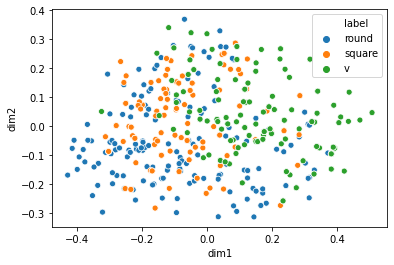

In [ ]:
sns.scatterplot(x = 'dim1', y='dim2' , hue='label', data=pca_df )

---

- target에 대한 사전셋(train-set)의 거리 범위 살피기
> eg. test객체인 label '0' 에 대한 30개의 가장 가까운 객체들의 label과 distance 저장하고, 이들의 distance-range를 살핀다 

In [ ]:
ttt_result = neigh.radius_neighbors(valid_features[0].reshape(1,-1), 1.0, return_distance=True)

In [ ]:
knn_distance_df = pd.DataFrame({'distance':ttt_result[0][0], 'valid_index':ttt_result[1][0] }).sort_values(by='distance').reset_index(drop=True)

In [ ]:
#
neigh = NearestNeighbors( n_neighbors=30 ) #radius : 1.0(default)
neigh.fit( train_features )


knn_distance_0 = pd.DataFrame()
knn_distance_1 = pd.DataFrame()
knn_distance_2 = pd.DataFrame()

for s_idx in range(len(valid_features)):
  
  ttt_result = neigh.radius_neighbors(valid_features[s_idx].reshape(1,-1), 1.0, return_distance=True)
  
  # 타겟에 대한, 30개의 가까운 distance+label 저장
  knn_distance_df = pd.DataFrame({'distance':ttt_result[0][0], 'valid_index':ttt_result[1][0] }).sort_values(by='distance').reset_index(drop=True)
  knn_distance_df = knn_distance_df.head(30)
  # label 붙여주기
  knn_distance_df = pd.merge(knn_distance_df, train_label_df, left_on='valid_index', right_index=True)


  if valid_y[s_idx] == 0:
    knn_distance_0 = pd.concat([knn_distance_0, knn_distance_df], axis=0)
  elif valid_y[s_idx] == 1:
    knn_distance_1 = pd.concat([knn_distance_1, knn_distance_df], axis=0)
  elif valid_y[s_idx] == 2:
    knn_distance_2 = pd.concat([knn_distance_2, knn_distance_df], axis=0)

In [ ]:
knn_distance_df.head()

,distance,valid_index,y_label
0,0.493078,306,2
1,0.493078,359,2
2,0.519242,209,1
3,0.525376,426,2
4,0.525753,403,2


In [ ]:
len(valid_features)

124

In [ ]:
knn_distance_0.shape

(1020, 2)

In [ ]:
knn_distance_1.shape

(1380, 2)

In [ ]:
knn_distance_2.shape

(1320, 2)

In [ ]:
124*30

3720

In [ ]:
knn_distance_0.head()

,distance,valid_index
0,0.425649,39
1,0.465409,218
2,0.468463,76
3,0.469052,236
4,0.469052,255


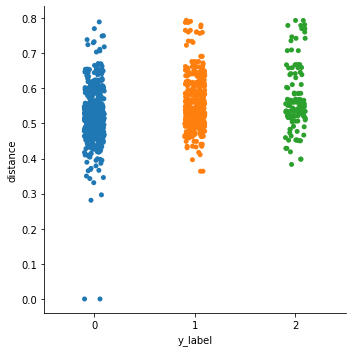

In [ ]:
import seaborn as sns

sns.catplot(x="y_label", y="distance", data=knn_distance_0)

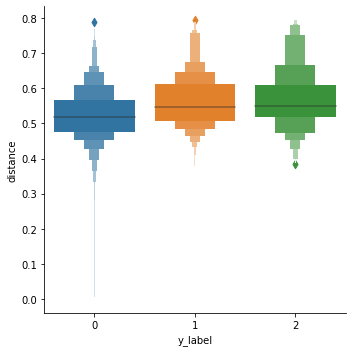

In [ ]:
sns.catplot(x="y_label", y="distance", kind='boxen',data=knn_distance_0)

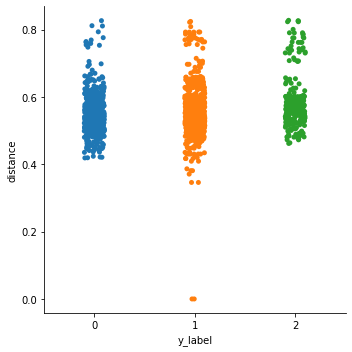

In [ ]:
sns.catplot(x="y_label", y="distance", data=knn_distance_1)

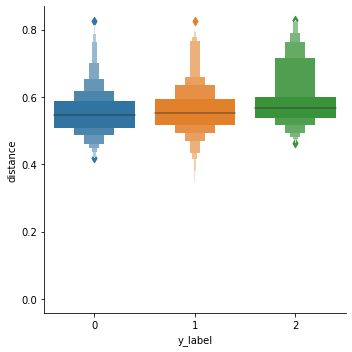

In [ ]:
sns.catplot(x="y_label", y="distance", kind='boxen', data=knn_distance_1)

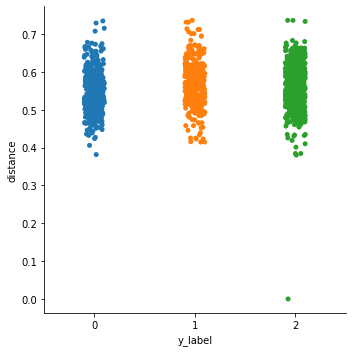

In [ ]:
sns.catplot(x="y_label", y="distance",  data=knn_distance_2)

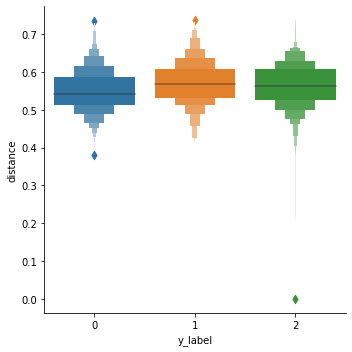

In [ ]:
sns.catplot(x="y_label", y="distance", kind='boxen', data=knn_distance_2)



---



---

